In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as cx

In [2]:
df = pd.read_excel('../Data/Sinkholes.xlsx', sheet_name='Spoed kademuren', header=3, usecols=[2, 3, 5, 6, 7, 11])

In [3]:
shapes = gpd.read_file('../Data/shape kademuren en bruggen/VPT_kademuren.shp')
shapes = shapes[['kunstwerkn', 'geometry']]
shapes['X_coordinate'] = shapes['geometry'].x
shapes['Y_coordinate'] = shapes['geometry'].y
shapes = shapes.drop('geometry', axis=1)
shapes = shapes.set_index('kunstwerkn')
shapes.index.name = None
shapes

,X_coordinate,Y_coordinate
HEG0102,121220.871500,487909.533000
HEG0802,121178.272000,486574.132500
LYG0501,120235.607000,487371.839500
OEV2491,121252.048268,490271.078733
PRG0402,120675.512500,487373.652500
...,...,...
SIG0803-01,120447.666500,486492.964000
SIG0803-02,120423.594500,486498.121000
SIG1101-01,121446.243751,485682.412750
SIN0903,121037.356500,486790.723500


In [4]:
df = df[df['Naam'].notna() & df['Aantal spoed door zinkgaten'].notna()]
df['Aantal spoed door zinkgaten'] = df['Aantal spoed door zinkgaten'].apply(str.lower)
# df = df[df['Aantal spoed door zinkgaten'].str.contains('zinkgat')]
df['Naam'] = df['Naam'].str[:7]
df.iloc[:,2].fillna(df.iloc[:,3], inplace=True)
df = df.drop([df.iloc[:,3].name, df.iloc[:,4].name], axis=1)
df = df.rename(columns={'Mellany CC app':'Date', 'Aantal spoed door zinkgaten':'Zinkgaten'})
df

,jaar,Naam,Date,Zinkgaten
5,2023.0,OSD0203,NaN,zinkgat
6,2023.0,LYG0301,NaN,zinkgat
7,2023.0,OVW0302,27-1-2023,zinkgat
14,2022.0,AMS0302,25-11-2022,spoedmelding zinkgat
15,2022.0,LYG0602,25-11-2022,spoedmelding zinkgat
20,2022.0,SIN0401,17-10-2022,spoedmelding zinkgat
21,2022.0,LYG0602,2022-02-08 00:00:00,spoedmelding zinkgat
22,2022.0,NAK0205,2022-09-08 00:00:00,"""verzakking"""
25,2022.0,HEG0101,22Q1,"""verzakking"""
26,2022.0,KVV0702,NaN,"""maaiveld verzakking"""


In [5]:
df_Y = pd.read_csv('../Data/TargetY.csv', index_col=0)

In [6]:
df_coords = df_Y.iloc[:,:3].groupby('objectid')['X_coordinate', 'Y_coordinate'].mean()
df = df.set_index('Naam')
df_coords2 = pd.concat([df_coords, shapes])
df_coords2 = df_coords2[~df_coords2.index.duplicated(keep='first')]

# changed df_coords2 to incorporate from shapefiles too.
df['X_coordinate'] = df_coords2['X_coordinate']
df['Y_coordinate'] = df_coords2['Y_coordinate']

C:\Users\julia\AppData\Local\Temp/ipykernel_18720/256028268.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_coords = df_Y.iloc[:,:3].groupby('objectid')['X_coordinate', 'Y_coordinate'].mean()


In [7]:
df = df[df['X_coordinate'].notna() & df['Y_coordinate'].notna()]

In [8]:
df['points'] = gpd.points_from_xy(df['X_coordinate'], df['Y_coordinate'])
gdf = gpd.GeoDataFrame(df, crs="EPSG:28992", geometry=df['points'])
gdf = gdf.to_crs("EPSG: 4326")

In [9]:
gdf

,jaar,Date,Zinkgaten,X_coordinate,Y_coordinate,points,geometry
Naam,,,,,,,
AMS0302,2022.0,25-11-2022,spoedmelding zinkgat,121882.238452,486458.444374,POINT (121882.238 486458.444),POINT (4.90098 52.36501)
LYG0602,2022.0,25-11-2022,spoedmelding zinkgat,120313.140145,486982.777475,POINT (120313.140 486982.777),POINT (4.87789 52.36963)
LYG0602,2022.0,2022-02-08 00:00:00,spoedmelding zinkgat,120313.140145,486982.777475,POINT (120313.140 486982.777),POINT (4.87789 52.36963)
KVV0702,2022.0,NaN,"""maaiveld verzakking""",118901.854469,486097.106623,POINT (118901.854 486097.107),POINT (4.85726 52.36158)
PRG0701,2022.0,23-2-2022,verzakking,120616.178621,486802.126424,POINT (120616.179 486802.126),POINT (4.88236 52.36802)
SIN0501,2022.0,16-11-2022,twee verzakkingen in maaiveld,121064.638283,487462.258578,POINT (121064.638 487462.259),POINT (4.88887 52.37398)
KAS0101,2022.0,NaN,opnieuw een maaiveldverzakking,120192.616413,488278.888050,POINT (120192.616 488278.888),POINT (4.87598 52.38127)
SIN0501,2021.0,21Q4,"""twee verzakkingen in het maaiveld""",121064.638283,487462.258578,POINT (121064.638 487462.259),POINT (4.88887 52.37398)
KVV0702,2021.0,NaN,maaiveldverzakking,118901.854469,486097.106623,POINT (118901.854 486097.107),POINT (4.85726 52.36158)


No handles with labels found to put in legend.


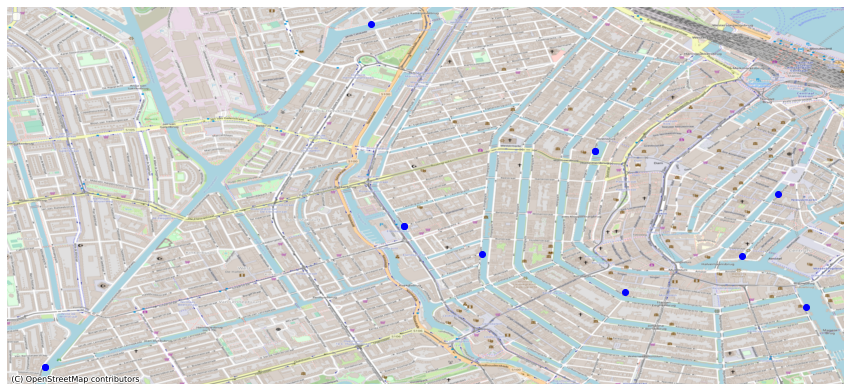

In [10]:
fig, ax = plt.subplots(figsize=(15,15))
gdf.plot(ax=ax, color='b')
cx.add_basemap(ax=ax, source=cx.providers.OpenStreetMap.Mapnik, crs=gdf.crs)
plt.legend(loc='upper left')
ax.axis('off')
plt.show()

In [45]:
gdf.to_csv('../Data/Sinkholes.csv', index=True)